## Ejercicio Práctico - Clase 2 VPC2 - 4co2021

Generar una red TP2olucional con las siguientes caracteristicas:

*   Conv1: cantidad de filtros=16, tramaño de filtro=3, stride=1, padding="same"
*   Pool1: MaxPooling, tamaño de filtro=2, stride=2
*   Conv2: cantidad de filtros=32, tramaño de filtro=3, stride=1, padding="same"
*   Pool2: MaxPooling, tamaño de filtro=2, stride=2
*   Conv3: cantidad de filtros=64, tramaño de filtro=3, stride=1, padding="same"
*   Pool3: MaxPooling, tamaño de filtro=2, stride=2
*   Conv4: cantidad de filtros=128, tramaño de filtro=3, stride=1, padding="same"
*   Linear1: cantidad de neuronas=100
*   Linear2: capa de salida

Elegir la función de activación que crean mas conveniente.

Ejercicios:

1.   Utilizando el dataset CIFAR10, provisto por PyTorch, entrenar la red sin aplicar data augmentation durante, al menos, 20 epocas. Se produce sobreentrenamiento?

#### RESPUESTA: Vemos en el gráfico que no se produce sobre-entrenamiento porque el error de validación sigue, en la curva, pegado al error de entrenamiento.

2.   Utilizando el mismo dataset y aplicando las tecnicas de data augmentation que considere necesarias, entrenar nuevamente la red durante, al menos, 20 epocas sin que se produzca sobreentrenamiento hasta alcanzar un accuracy de 80% aproximadamente.
3.   A partir de los resultados obtenidos en los puntos anteriores: ¿Por qué cree que en el segundo caso el ritmo de mejora de la red es mas lento que en el primero?

#### RESPUESTA: En el segundo caso vemos que la convergencia es mas lenta debido a que se entrena con mini-batches compuestos de imagenes transformadas, las cuales estan mas correlacionadas entre sí. En este caso el aprendizaje del modelo se produce de manera mas lenta época a época pero permite hacer un número mayor de iteraciones debido a tener un dataset mas grande.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import tensorflow as tf
import torch.nn.functional as F
import torchvision
import torchsummary
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
!pip install torchmetrics
import torchmetrics

     |████████████████████████████████| 409 kB 27.5 MB/s 


In [ ]:
# Generamos la red neuronal
class TP2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.fc1 = torch.nn.Linear(in_features=2048, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = torch.relu(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
TP2_model = TP2()
# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    TP2_model.to("cuda")

In [ ]:
torchsummary.summary(TP2_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         AvgPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         AvgPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         AvgPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
            Linear-8                  [-1, 100]         204,900
            Linear-9                   [-1, 10]           1,010
Total params: 303,350
Trainable params: 303,350
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 1.16
Estimated Total Size (MB): 1.46
-------------------------------------------

In [ ]:
# definimos un optimizador, una función de error y una función de métrica.
lr = 0.01
TP2_model_optimizer = torch.optim.SGD(TP2_model.parameters(), lr=lr)
TP2_model_loss = torch.nn.CrossEntropyLoss()
TP2_model_accuracy = torchmetrics.Accuracy()

In [ ]:
# Una vez definido el modelo, cargo el dataset SIFAR10
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
#train, test = tf.keras.datasets.cifar10.load_data()
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

# Creamos un conjunto de validación a partir del conjunto de entrenamiento
valid_set_size = 10000
train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])
print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Tamaño del conjunto de entrenamiento: 40000
Tamaño del conjunto de validación: 10000


In [ ]:

# Creamos el objeto dataloader para iterar sobre el dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)



In [ ]:
if torch.cuda.is_available():
  TP2_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    TP2_model_optimizer.zero_grad()
    
    output = TP2_model(train_data)
    
    loss = TP2_model_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    TP2_model_optimizer.step()

    accuracy = TP2_model_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = TP2_model(valid_data)
    epoch_valid_loss += TP2_model_loss(output, valid_target).item()
    epoch_valid_accuracy += TP2_model_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 2.302856 - Train Accuracy 0.101250 - Valid Loss 2.302112 - Valid Accuracy 0.096700
Epoch: 2/20 - Train loss 2.301102 - Train Accuracy 0.125375 - Valid Loss 2.299381 - Valid Accuracy 0.178600
Epoch: 3/20 - Train loss 2.277114 - Train Accuracy 0.155825 - Valid Loss 2.170654 - Valid Accuracy 0.219000
Epoch: 4/20 - Train loss 2.040445 - Train Accuracy 0.253400 - Valid Loss 1.961819 - Valid Accuracy 0.284100
Epoch: 5/20 - Train loss 1.919065 - Train Accuracy 0.305175 - Valid Loss 1.842033 - Valid Accuracy 0.339500
Epoch: 6/20 - Train loss 1.796897 - Train Accuracy 0.357075 - Valid Loss 1.761788 - Valid Accuracy 0.367400
Epoch: 7/20 - Train loss 1.705094 - Train Accuracy 0.392075 - Valid Loss 1.653263 - Valid Accuracy 0.405000
Epoch: 8/20 - Train loss 1.632345 - Train Accuracy 0.413650 - Valid Loss 1.595519 - Valid Accuracy 0.424400
Epoch: 9/20 - Train loss 1.578422 - Train Accuracy 0.432300 - Valid Loss 1.538806 - Valid Accuracy 0.439200
Epoch: 10/20 - Train loss 1.

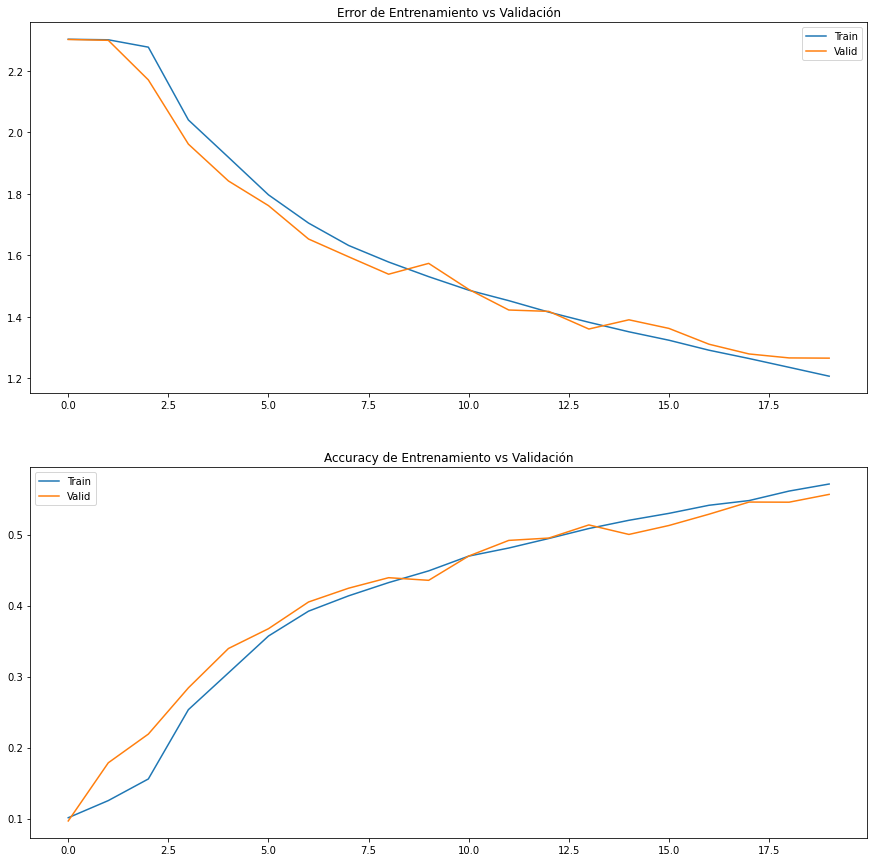

In [ ]:
# visualizamos los resultados:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = TP2_model(test_data)
  test_loss += TP2_model_loss(output, test_target).item()
  test_accuracy += TP2_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 1.270882 y una accuracy de 0.555200


Files already downloaded and verified
Tamaño del conjunto de entrenamiento: 40000
Tamaño del conjunto de validación: 10000


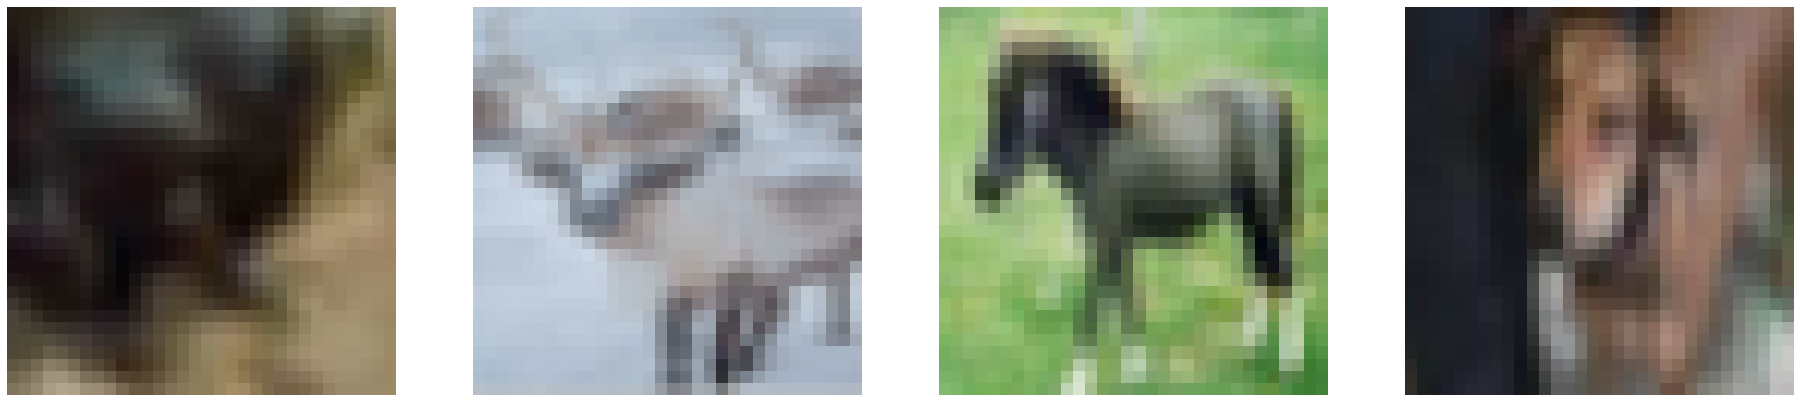

In [ ]:
# Aplicamos Data Augmentation
aud_data_transforms = torchvision.transforms.Compose([
                        
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                      ])

aug_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=aud_data_transforms)

# Creamos un conjunto de validación a partir del conjunto de entrenamiento
valid_set_size = 10000
aug_train_set, aug_valid_set = torch.utils.data.random_split(aug_train_set, [len(aug_train_set) - valid_set_size, valid_set_size])
print("Tamaño del conjunto de entrenamiento: {}".format(len(aug_train_set)))
print("Tamaño del conjunto de validación: {}".format(len(aug_valid_set)))

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

# Visualizamos el resultado: 
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(32, 32))
for id, row in enumerate(rows):
    row.imshow(aug_train_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

In [ ]:
# Volvemos a entrenar el modelo, ahora con los datos aumentados:
aug_TP2_model = TP2()
# definimos un optimizador, una función de error y una función de métrica.

if torch.cuda.is_available():
  aug_TP2_model = aug_TP2_model.to("cuda")

lr = 0.01
aug_TP2_model_optimizer = torch.optim.SGD(aug_TP2_model.parameters(), lr=lr)
aug_TP2_model_loss = torch.nn.CrossEntropyLoss()
aug_TP2_model_accuracy = torchmetrics.Accuracy()


if torch.cuda.is_available():
  aug_TP2_model_accuracy = aug_TP2_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 150

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for aug_train_data, aug_train_target in aug_train_loader:

    if torch.cuda.is_available():
      aug_train_data = aug_train_data.to("cuda")
      aug_train_target = aug_train_target.to("cuda")

    aug_TP2_model_optimizer.zero_grad()
    
    aug_output = aug_TP2_model(aug_train_data)
    
    aug_loss = aug_TP2_model_loss(aug_output, aug_train_target)
    epoch_train_loss += aug_loss.item()
    aug_loss.backward()
    
    aug_TP2_model_optimizer.step()
    accuracy = aug_TP2_model_accuracy(aug_output, aug_train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(aug_train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(aug_train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for aug_valid_data, aug_valid_target in aug_valid_loader:
    if torch.cuda.is_available():
      aug_valid_data = aug_valid_data.to("cuda")
      aug_valid_target = aug_valid_target.to("cuda")

    aug_output = aug_TP2_model(aug_valid_data)
    epoch_valid_loss += aug_TP2_model_loss(aug_output, aug_valid_target).item()
    epoch_valid_accuracy += aug_TP2_model_accuracy(aug_output, aug_valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(aug_valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(aug_valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/150 - Train loss 2.302812 - Train Accuracy 0.105225 - Valid Loss 2.301960 - Valid Accuracy 0.095647
Epoch: 2/150 - Train loss 2.299849 - Train Accuracy 0.133000 - Valid Loss 2.294884 - Valid Accuracy 0.154453
Epoch: 3/150 - Train loss 2.194232 - Train Accuracy 0.184975 - Valid Loss 2.066966 - Valid Accuracy 0.230831
Epoch: 4/150 - Train loss 2.034897 - Train Accuracy 0.243100 - Valid Loss 2.006264 - Valid Accuracy 0.252696
Epoch: 5/150 - Train loss 1.974401 - Train Accuracy 0.271100 - Valid Loss 1.928294 - Valid Accuracy 0.295827
Epoch: 6/150 - Train loss 1.906968 - Train Accuracy 0.310550 - Valid Loss 1.876269 - Valid Accuracy 0.324281
Epoch: 7/150 - Train loss 1.843641 - Train Accuracy 0.335000 - Valid Loss 1.819749 - Valid Accuracy 0.348442
Epoch: 8/150 - Train loss 1.786853 - Train Accuracy 0.356050 - Valid Loss 1.753298 - Valid Accuracy 0.365715
Epoch: 9/150 - Train loss 1.736512 - Train Accuracy 0.368650 - Valid Loss 1.736455 - Valid Accuracy 0.373802
Epoch: 10/150 - Tra

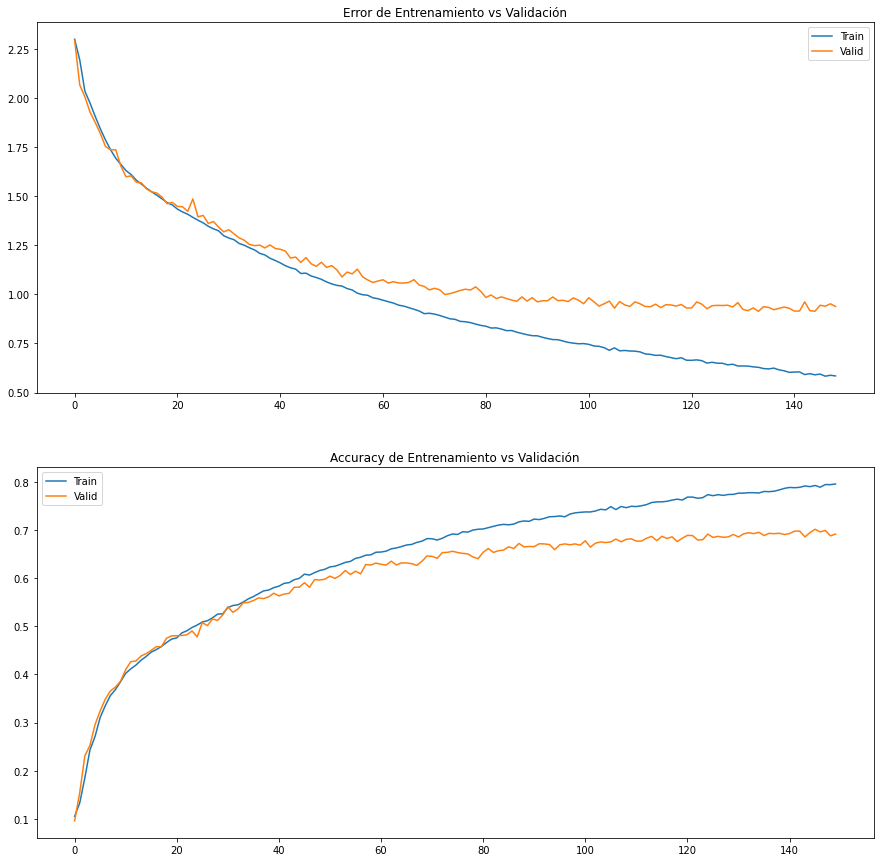

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = aug_TP2_model(test_data)
  test_loss += aug_TP2_model_loss(output, test_target).item()
  test_accuracy += aug_TP2_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.917591 y una accuracy de 0.710100
